Разархивировать датасет

In [1]:
import tarfile
with tarfile.open('ap.tgz', 'r:gz') as tar:
    tar.extractall('')

C:\Users\nikita\AppData\Local\Temp\ipykernel_5236\1814984170.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall('')


In [ ]:
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from collections import Counter
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA


загрузка датасета

In [3]:
corpus = corpora.BleiCorpus('ap/ap.dat', 'ap/vocab.txt')
print(f"Документов в корпусе: {len(corpus)}")

Документов в корпусе: 2246


Построение модели

Темы первого документа: [(0, 0.035488207), (1, 0.01571224), (2, 0.3590259), (7, 0.06559337), (9, 0.5222826)]


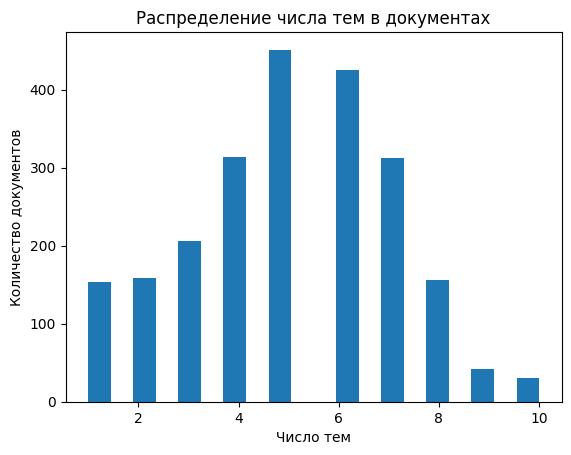

Тема 0: [('i', 0.010389985), ('bush', 0.009717177), ('percent', 0.009386248), ('dukakis', 0.008017291), ('new', 0.007223917), ('president', 0.0060790945), ('campaign', 0.0057331035), ('vote', 0.005205742), ('state', 0.0048504383), ('people', 0.004490004)]
Тема 1: [('people', 0.007615224), ('percent', 0.0060882736), ('children', 0.006078348), ('aids', 0.0057318667), ('drug', 0.0050455607), ('water', 0.0046933824), ('year', 0.004687196), ('i', 0.0046455455), ('study', 0.0045356383), ('national', 0.0045258314)]
Тема 2: [('i', 0.00644386), ('first', 0.0045542386), ('years', 0.004536217), ('two', 0.0044313967), ('three', 0.00425714), ('people', 0.0042126104), ('fire', 0.0037404187), ('just', 0.003255617), ('american', 0.003164378), ('million', 0.0031519814)]
Тема 3: [('soviet', 0.013485117), ('west', 0.009474884), ('german', 0.008095745), ('germany', 0.0076724268), ('late', 0.007473525), ('dollar', 0.007357249), ('east', 0.006784703), ('yen', 0.0057343105), ('united', 0.0056857653), ('londo

In [4]:
model = models.LdaModel(corpus, id2word=corpus.id2word, num_topics=10, passes=10)
doc = corpus.docbyoffset(0)
topics = model[doc]
print("Темы первого документа:", topics)

num_topics_used = [len(model[doc]) for doc in corpus]

plt.hist(num_topics_used, bins=20)
plt.xlabel("Число тем")
plt.ylabel("Количество документов")
plt.title("Распределение числа тем в документах")
plt.show()

for ti in range(10):
    words = model.show_topic(ti, 10)
    print(f"Тема {ti}: {words}")


Предобработка

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text.lower())
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

with open('ap/ap.txt', 'r') as f:
    texts = f.readlines()

processed_texts = [preprocess_text(text) for text in texts]

dictionary = corpora.Dictionary(processed_texts)
dictionary.save_as_text('ap/vocab_processed.txt')

corpus = [dictionary.doc2bow(text) for text in processed_texts]
corpora.BleiCorpus.serialize('ap/ap_processed.dat', corpus, dictionary)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
corpus = corpora.BleiCorpus('ap/ap_processed.dat', 'ap/vocab_processed.txt')
model = models.LdaModel(corpus, id2word=dictionary, num_topics=10, passes=10)

Определение качества модели

In [12]:
def compute_coherence_values(corpus, dictionary, texts, start, step, limit):
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append((num_topics, coherencemodel.get_coherence()))
    return coherence_values

coherence_values = compute_coherence_values(corpus, dictionary, processed_texts, start=5, step=5, limit=50)


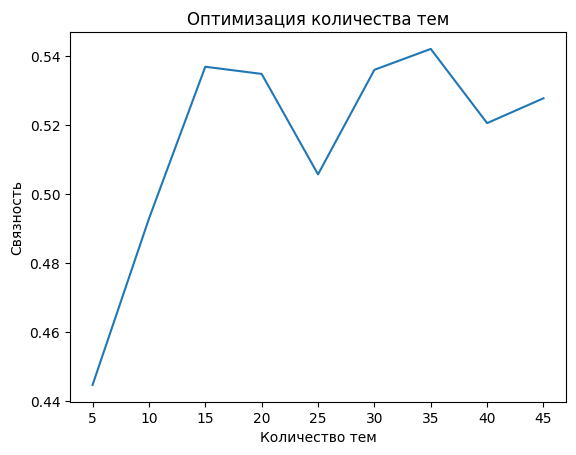

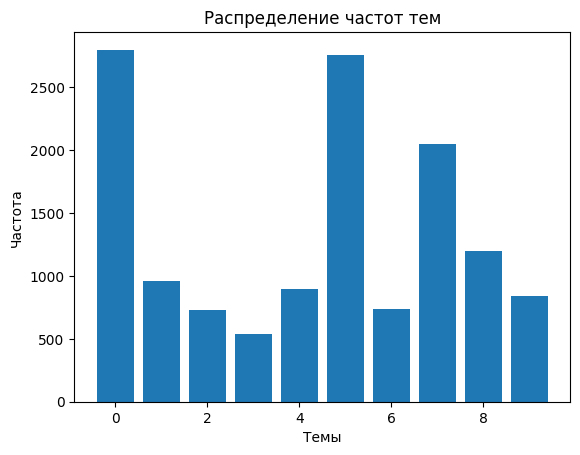

In [29]:
x, y = zip(*coherence_values)
plt.plot(x, y)
plt.xlabel("Количество тем")
plt.ylabel("Связность")
plt.title("Оптимизация количества тем")
plt.show()

topic_weights = [dict(model.get_document_topics(doc, minimum_probability=0)) for doc in corpus]

num_topics = model.num_topics
topic_distribution = np.zeros(num_topics)

for tw in topic_weights:
    for topic_id, weight in tw.items():
        topic_distribution[topic_id] += weight

plt.bar(range(len(topic_distribution)), topic_distribution)
plt.xlabel("Темы")
plt.ylabel("Частота")
plt.title("Распределение частот тем")
plt.show()


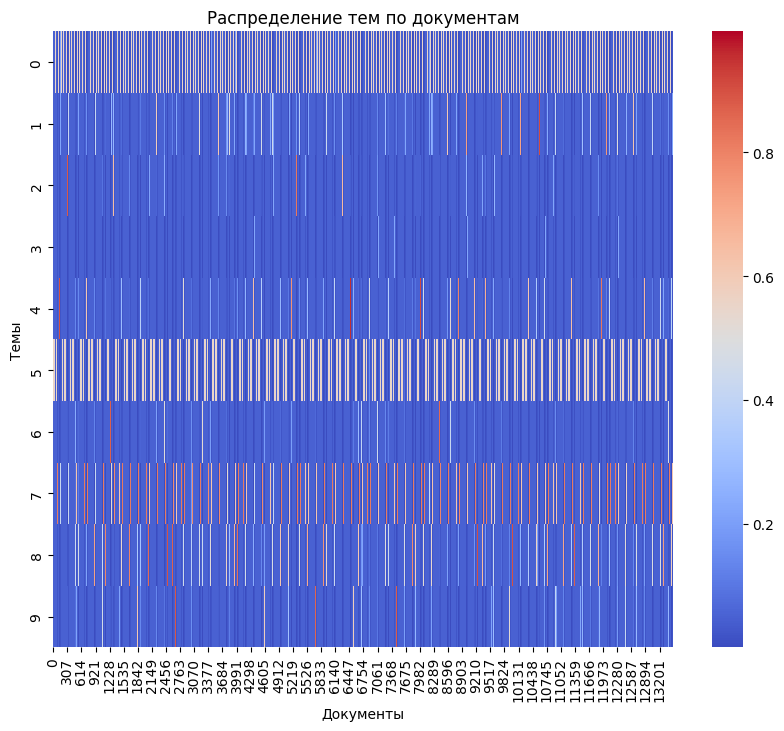

In [26]:
topic_weights = [dict(model.get_document_topics(doc, minimum_probability=0)) for doc in corpus]

df_topic_weights = pd.DataFrame(topic_weights).fillna(0)

plt.figure(figsize=(10, 8))
sns.heatmap(df_topic_weights.T, cmap="coolwarm", cbar=True)
plt.xlabel("Документы")
plt.ylabel("Темы")
plt.title("Распределение тем по документам")
plt.show()


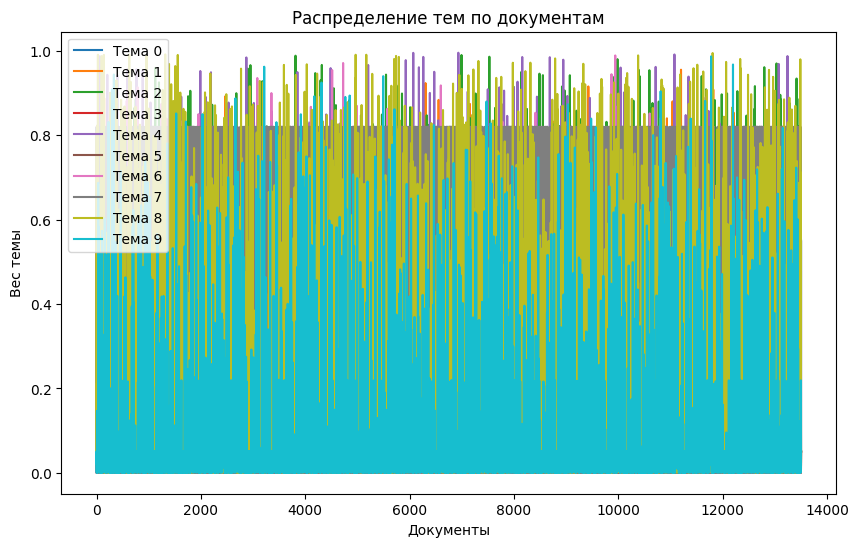

In [27]:
topic_weights_array = np.array([list(tw.values()) for tw in topic_weights])

plt.figure(figsize=(10, 6))
for i in range(topic_weights_array.shape[1]):
    plt.plot(topic_weights_array[:, i], label=f"Тема {i}")

plt.xlabel("Документы")
plt.ylabel("Вес темы")
plt.title("Распределение тем по документам")
plt.legend()
plt.show()


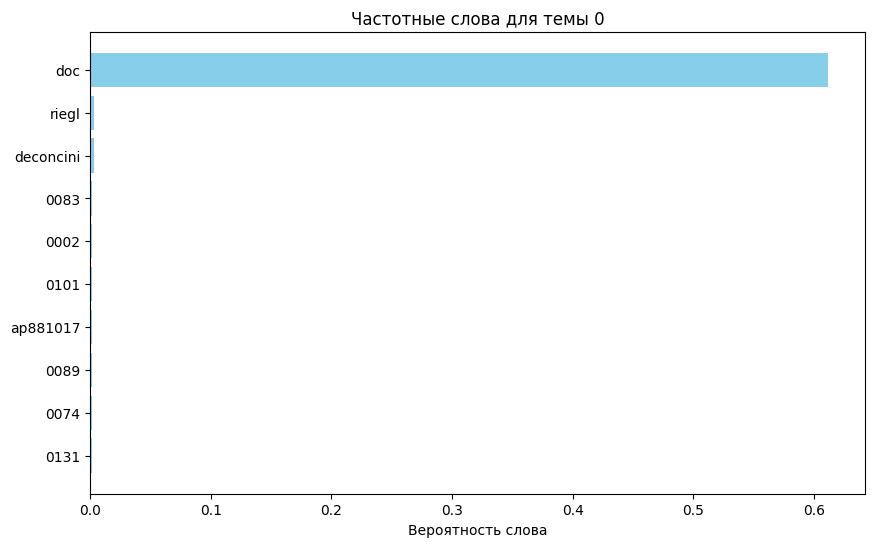

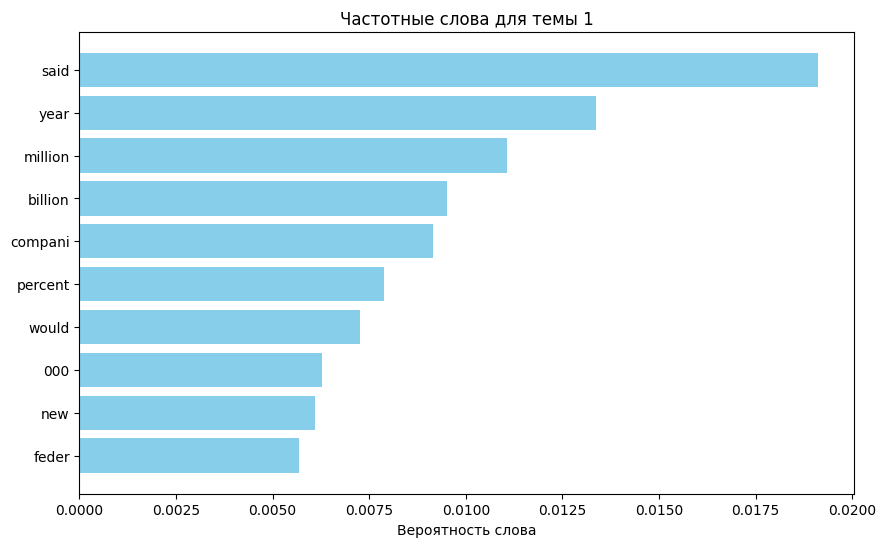

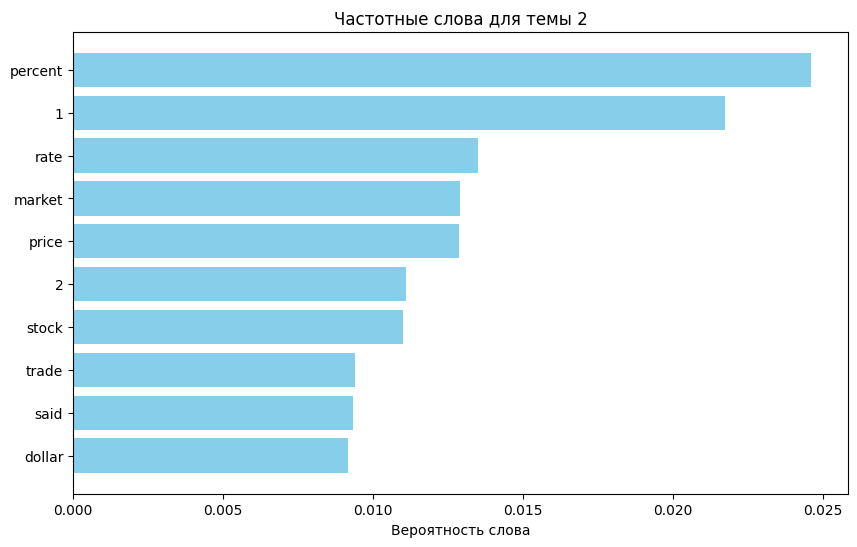

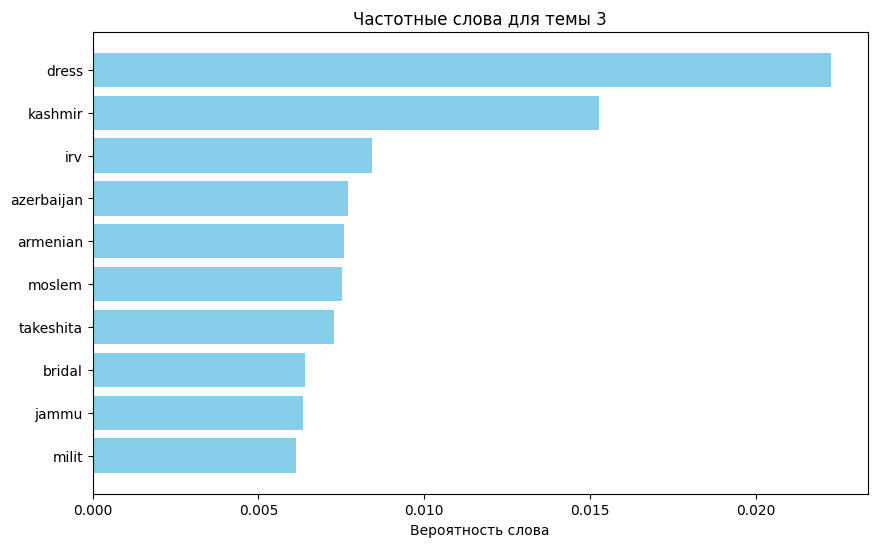

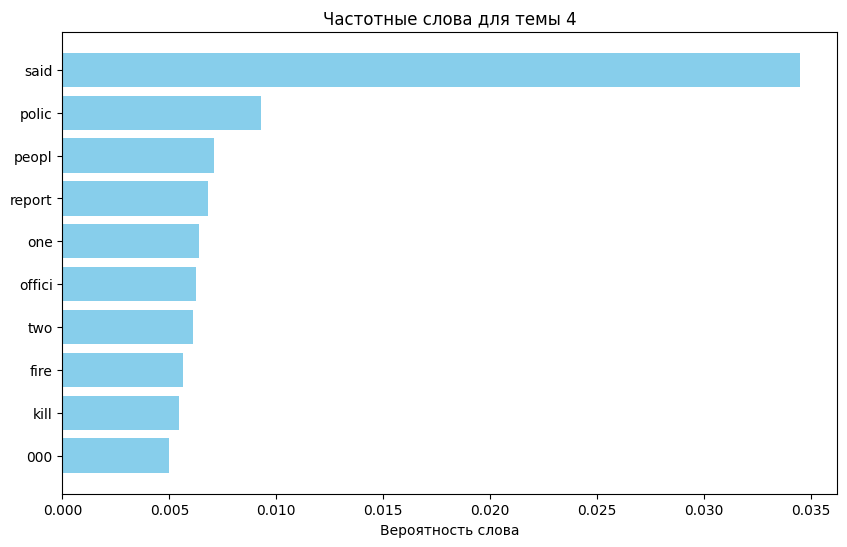

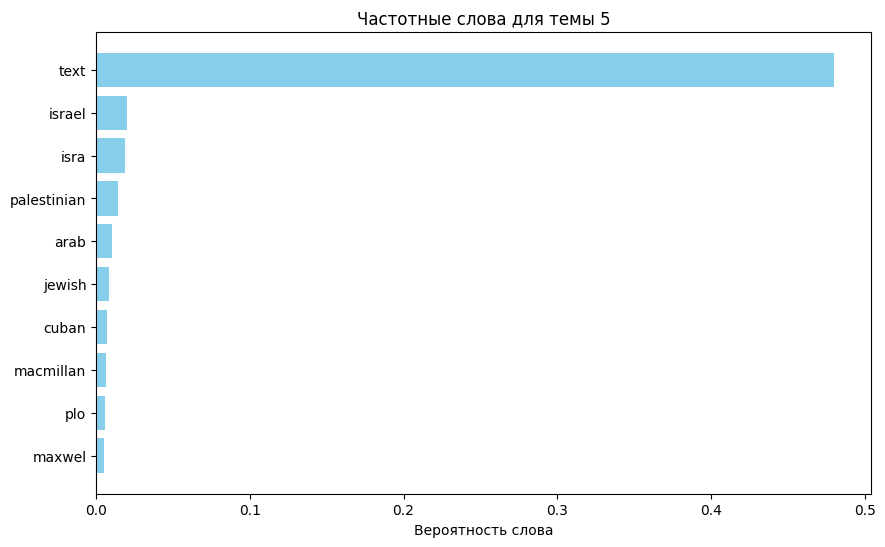

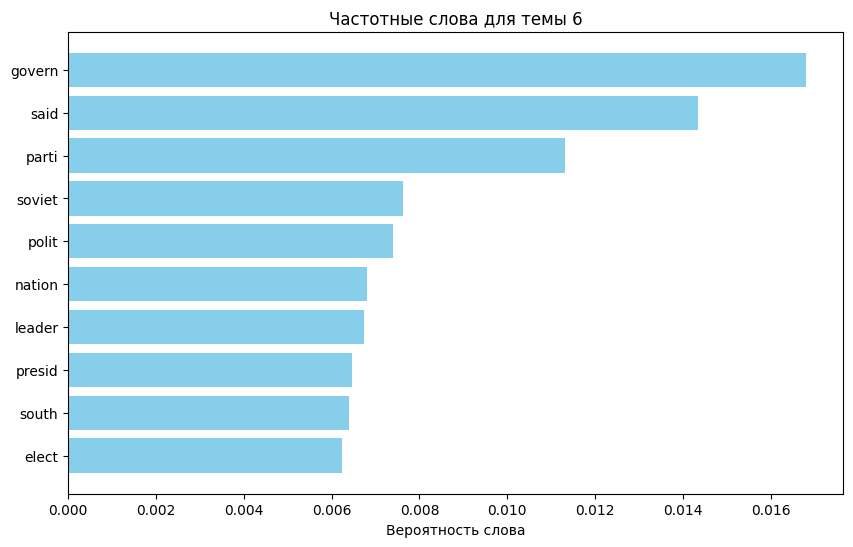

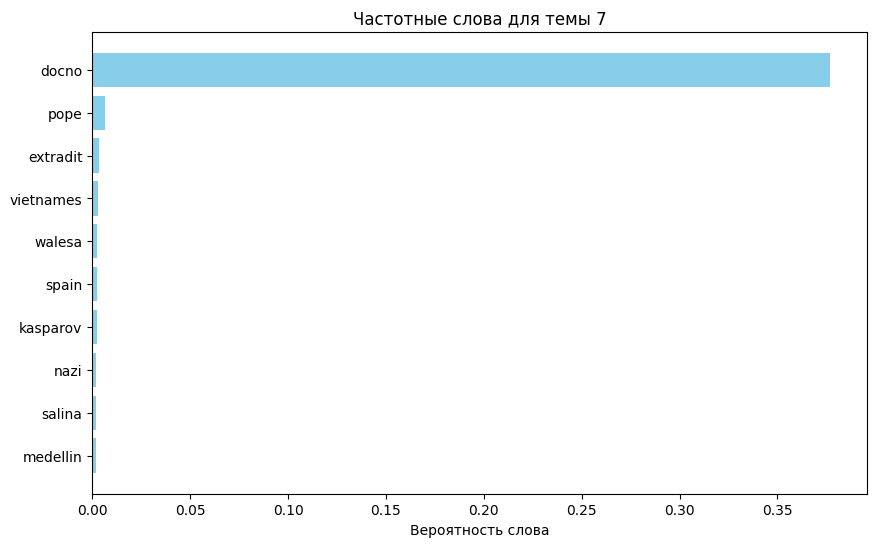

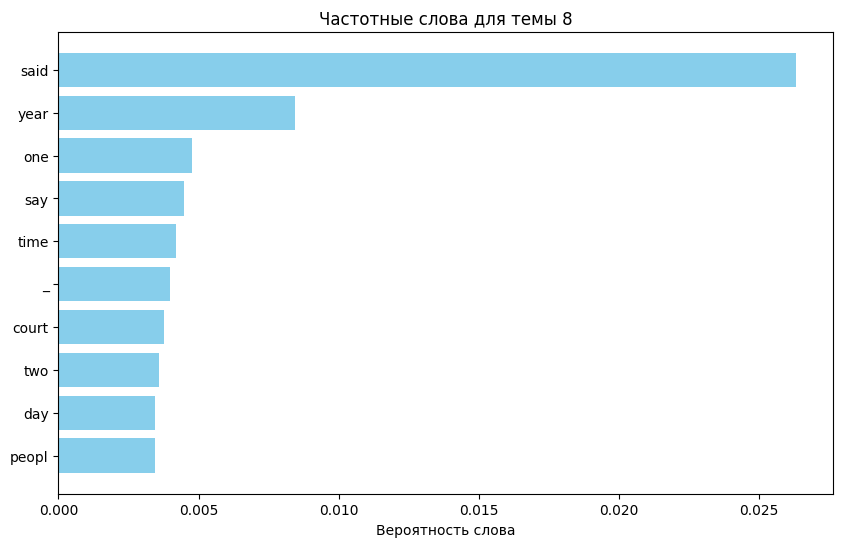

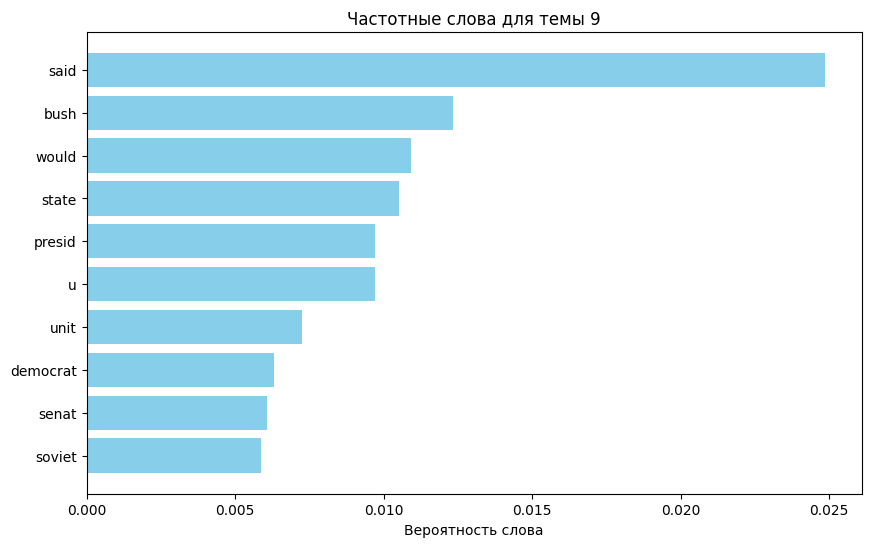

In [ ]:
num_top_words = 10

for ti in range(model.num_topics):
    words = model.show_topic(ti, num_top_words)
    words = [word for word, _ in words]
    weights = [weight for _, weight in model.show_topic(ti, num_top_words)]

    plt.figure(figsize=(10, 6))
    plt.barh(words, weights, color='skyblue')
    plt.xlabel('Вероятность слова')
    plt.title(f'Частотные слова для темы {ti}')
    plt.gca().invert_yaxis()
    plt.show()
